In [1]:
# imports
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.linear_model as linear_model
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import copy

In [2]:
# original ames dataframe
ames_df = pd.read_csv("../data/AmesHousing.txt", sep="\t")

Let's check if we have any duplicate PID:

In [3]:
len(ames_df["PID"]) == len(set(ames_df["PID"]))

True

In [4]:
# for the purpose of this project, let's drop PID column since it's a unique identifier.
ames_df = ames_df.drop('PID', axis=1)
ames_df_columns = ames_df.columns
# len(ames_df_columns)
# ames_df_labels = ames_df.pop('SalePrice')

In [5]:
# for experimenting
ames_df2 = copy.copy(ames_df)
train = copy.copy(ames_df)
df = copy.copy(train)

In [7]:
# general feature information
ames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
Order              2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2

In [6]:
# get counts of feature types
ames_df.get_dtype_counts()

float64    11
int64      27
object     43
dtype: int64

In [8]:
ames_df.head()

,Order,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [14]:
ames_df_rows_n, ames_df_columns_n = ames_df.shape
print("rows = {0} columns = {1}".format(ames_df_rows_n,ames_df_columns_n))

rows = 2930 columns = 81


Categorical (Nominal): A categorical variable is one that has two or more categories, but there is no intrinsic ordering to the categories.  e.g.- house style- 1 story, 2 story etc.

Ordinal: An ordinal variable is similar to a categorical variable but there is a clear ordering of the variables. e.g.- pool quality.

In [15]:
quantitative = list(ames_df._get_numeric_data().columns)
print("Quantitative variables are:\n")
print(quantitative)

qualitative = list(set(ames_df_columns) - set(quantitative))
print("\nQualitative variables are:\n")
print(qualitative)

Quantitative variables are:

['Order', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']

Qualitative variables are:

['Misc Feature', 'Condition 2', 'Pool QC', 'Garage Qual', 'BsmtFin Type 2', 'Land Slope', 'Kitchen Qual', 'MS Zoning', 'Lot Config', 'Central Air', 'Garage Type', 'Roof Style', 'BsmtFin Type 1', 'Mas Vnr Type', 'Condition 1', 'Utilities', 'Paved Drive', 'Functional', 'Land Contour', 'Bsmt Exposure', 'Sale Type', 'Bsmt Qual', 'Foundation', 'House Style', 'Bldg Type',

Electrical           1
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 1         1
BsmtFin SF 2         1
Garage Cars          1
Bsmt Full Bath       2
Bsmt Half Bath       2
Mas Vnr Area        23
Mas Vnr Type        23
BsmtFin Type 1      80
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 2      81
Bsmt Exposure       83
Garage Type        157
Garage Finish      159
Garage Qual        159
Garage Cond        159
Garage Yr Blt      159
Lot Frontage       490
Fireplace Qu      1422
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
dtype: int64

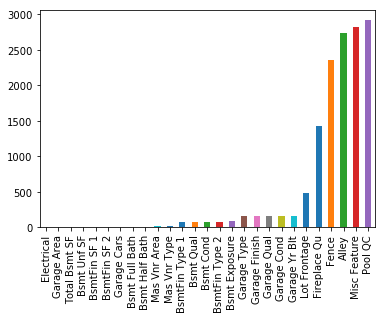

In [16]:
# check for missing quantities
missing_ames = ames_df.isnull().sum()
missing_ames_print = missing_ames[missing_ames > 0]
missing_ames_print = missing_ames_print.sort_values()
missing_ames_print.plot.bar()
missing_ames_print

In [22]:
# check for missing quantitaties in qualitative and quantitative individually
missing_quant = missing_ames[qualitative] 
missing_quant['SalePrice'] = 0
missing_quant = missing_quant[missing_quant>0]
missing_quant_df = pd.DataFrame()
missing_quant_df['count']= missing_quant
missing_quant_df

,count
Misc Feature,2824
Pool QC,2917
Garage Qual,159
BsmtFin Type 2,81
Garage Type,157
BsmtFin Type 1,80
Mas Vnr Type,23
Bsmt Exposure,83
Bsmt Qual,80
Garage Cond,159


In [23]:
# drop columns with too many missing values
ames_df = ames_df.drop(['Alley','Pool QC','Misc Feature', 'Fence', 'Fireplace Qu'], axis=1)
ames_df.shape

(2930, 76)

In [25]:
missing_qual=missing_ames[quantitative]
missing_qual['SalePrice']=0
missing_qual=missing_qual[missing_qual>0]
missing_qual_df= pd.DataFrame()
missing_qual_df['Count']= missing_qual
missing_qual_df

,Count
Lot Frontage,490
Mas Vnr Area,23
BsmtFin SF 1,1
BsmtFin SF 2,1
Bsmt Unf SF,1
Total Bsmt SF,1
Bsmt Full Bath,2
Bsmt Half Bath,2
Garage Yr Blt,159
Garage Cars,1


In [26]:
# drop rows with NAs
# print NA columns
'''
ind = ames_df['Garage Area'].isnull()
ames_df[ind]['Garage Area']
'''
# multiple ways to drop na
ames_df = ames_df.dropna(subset = ['Electrical','Garage Area', 'Total Bsmt SF', 'Bsmt Unf SF', 
                                   'BsmtFin SF 1','Garage Cars', 'BsmtFin SF 2', 'Bsmt Full Bath', 
                                   'Bsmt Half Bath', 'Mas Vnr Area', 'Mas Vnr Type'])
# ames_df = ames_df[np.isfinite(ames_df['Garage Area'])]
# ames_df = ames_df[pd.notnull(ames_df['Garage Area'])]

ames_df.shape

(2903, 76)

In [27]:
# fill NAs in other places

ames_df['MS Zoning'] = ames_df['MS Zoning'].fillna(ames_df['MS Zoning'].mode()[0])

ames_df['Lot Frontage'] = ames_df['Lot Frontage'].fillna(ames_df['Lot Frontage'].mean())

ames_df['Mas Vnr Type'] = ames_df['Mas Vnr Type'].fillna(ames_df['Mas Vnr Type'].mode()[0])

ames_df['Mas Vnr Area'] = ames_df['Mas Vnr Area'].fillna(ames_df['Mas Vnr Area'].mean())

for col in ('Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2'):
    ames_df[col] = ames_df[col].fillna('NoBSMT')

ames_df['BsmtFin SF 1'] = ames_df['BsmtFin SF 1'].fillna(0)   
ames_df['BsmtFin SF 2'] = ames_df['BsmtFin SF 2'].fillna(0)  
    
ames_df['Bsmt Full Bath'] = ames_df['Bsmt Full Bath'].fillna(ames_df['Bsmt Full Bath'].median())
ames_df['Bsmt Half Bath'] = ames_df['Bsmt Half Bath'].fillna(ames_df['Bsmt Half Bath'].median())

ames_df['Bsmt Unf SF'] = ames_df['Bsmt Unf SF'].fillna(ames_df['Bsmt Unf SF'].mean())

ames_df['Exterior 1st'] = ames_df['Exterior 1st'].fillna(ames_df['Exterior 1st'].mode()[0])
ames_df['Exterior 2nd'] = ames_df['Exterior 2nd'].fillna(ames_df['Exterior 2nd'].mode()[0])

ames_df['Functional'] = ames_df['Functional'].fillna(ames_df['Functional'].mode()[0])

ames_df['Total Bsmt SF'] = ames_df['Total Bsmt SF'].fillna(0)

ames_df['Electrical'] = ames_df['Electrical'].fillna(ames_df['Electrical'].mode()[0])

ames_df['Kitchen Qual'] = ames_df['Kitchen Qual'].fillna(ames_df['Kitchen Qual'].mode()[0])

ames_df['Garage Area'] = ames_df['Garage Area'].fillna(0.0)

for col in ('Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond'):
    ames_df[col] = ames_df[col].fillna('NoGRG')

ames_df['Garage Cars'] = ames_df['Garage Cars'].fillna(0)

ames_df['Sale Type'] = ames_df['Sale Type'].fillna(ames_df['Sale Type'].mode()[0])

ames_df['Utilities'] = ames_df['Utilities'].fillna(ames_df['Utilities'].mode()[0])

ames_df['Total SF'] = ames_df['Total Bsmt SF'] + ames_df['1st Flr SF'] + ames_df['2nd Flr SF']
ames_df.drop(['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Garage Yr Blt'], axis=1, inplace=True)

In [28]:
ames_df.shape

(2903, 73)

In [30]:
# restore the qualitative and quantitative cols

ames_df_columns = ames_df.columns
quantitative = list(ames_df._get_numeric_data().columns)
print("Quantitative variables are:\n")
print(quantitative)

qualitative = list(set(ames_df_columns) - set(quantitative))
print("\nQualitative variables are:\n")
print(qualitative)

Quantitative variables are:

['Order', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice', 'Total SF']

Qualitative variables are:

['Condition 2', 'Garage Qual', 'BsmtFin Type 2', 'Kitchen Qual', 'Land Slope', 'MS Zoning', 'Lot Config', 'Central Air', 'Garage Type', 'Roof Style', 'BsmtFin Type 1', 'Mas Vnr Type', 'Condition 1', 'Utilities', 'Paved Drive', 'Functional', 'Land Contour', 'Bsmt Exposure', 'Sale Type', 'Bsmt Qual', 'Foundation', 'House Style', 'Bldg Type', 'Heating QC', 'Street', 'Lot Shape', 'Exterior 2nd', 'Exter Qual', 'Garage C

In [33]:
# Encoding qualitative variables
# can i use one-hot encoding here? if yes, how?
# df_name = train

idx = 0

# probably won't need this but still storing it just in case.
mapping_list = []
for variable in qualitative:
    # unable to get this to work- see this
    # https://stackoverflow.com/questions/6181935/how-do-you-create-different-variable-names-while-in-a-loop
    # mapping_index = "mapping_index_" + str(idx)
    # print(mapping_index)
    ames_df[variable], mapping_index = pd.Series(ames_df[variable]).factorize()
    # idx += 1
    mapping_list.append(mapping_index)

In [ ]:
# approach 2 for encoding qualitative variables
# train.Street = pd.Categorical(train.Street).codes

In [34]:
ames_df.head()

,Order,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Total SF
0,1,20,0,141.0,31770,0,0,0,0,0,...,0,0,0,0,5,2010,0,0,215000,2736.0
1,2,20,1,80.0,11622,0,1,0,0,1,...,0,120,0,0,6,2010,0,0,105000,1778.0
2,3,20,0,81.0,14267,0,0,0,0,0,...,0,0,0,12500,6,2010,0,0,172000,2658.0
3,4,20,0,93.0,11160,0,1,0,0,0,...,0,0,0,0,4,2010,0,0,244000,4220.0
4,5,60,0,74.0,13830,0,0,0,0,1,...,0,0,0,0,3,2010,0,0,189900,2557.0


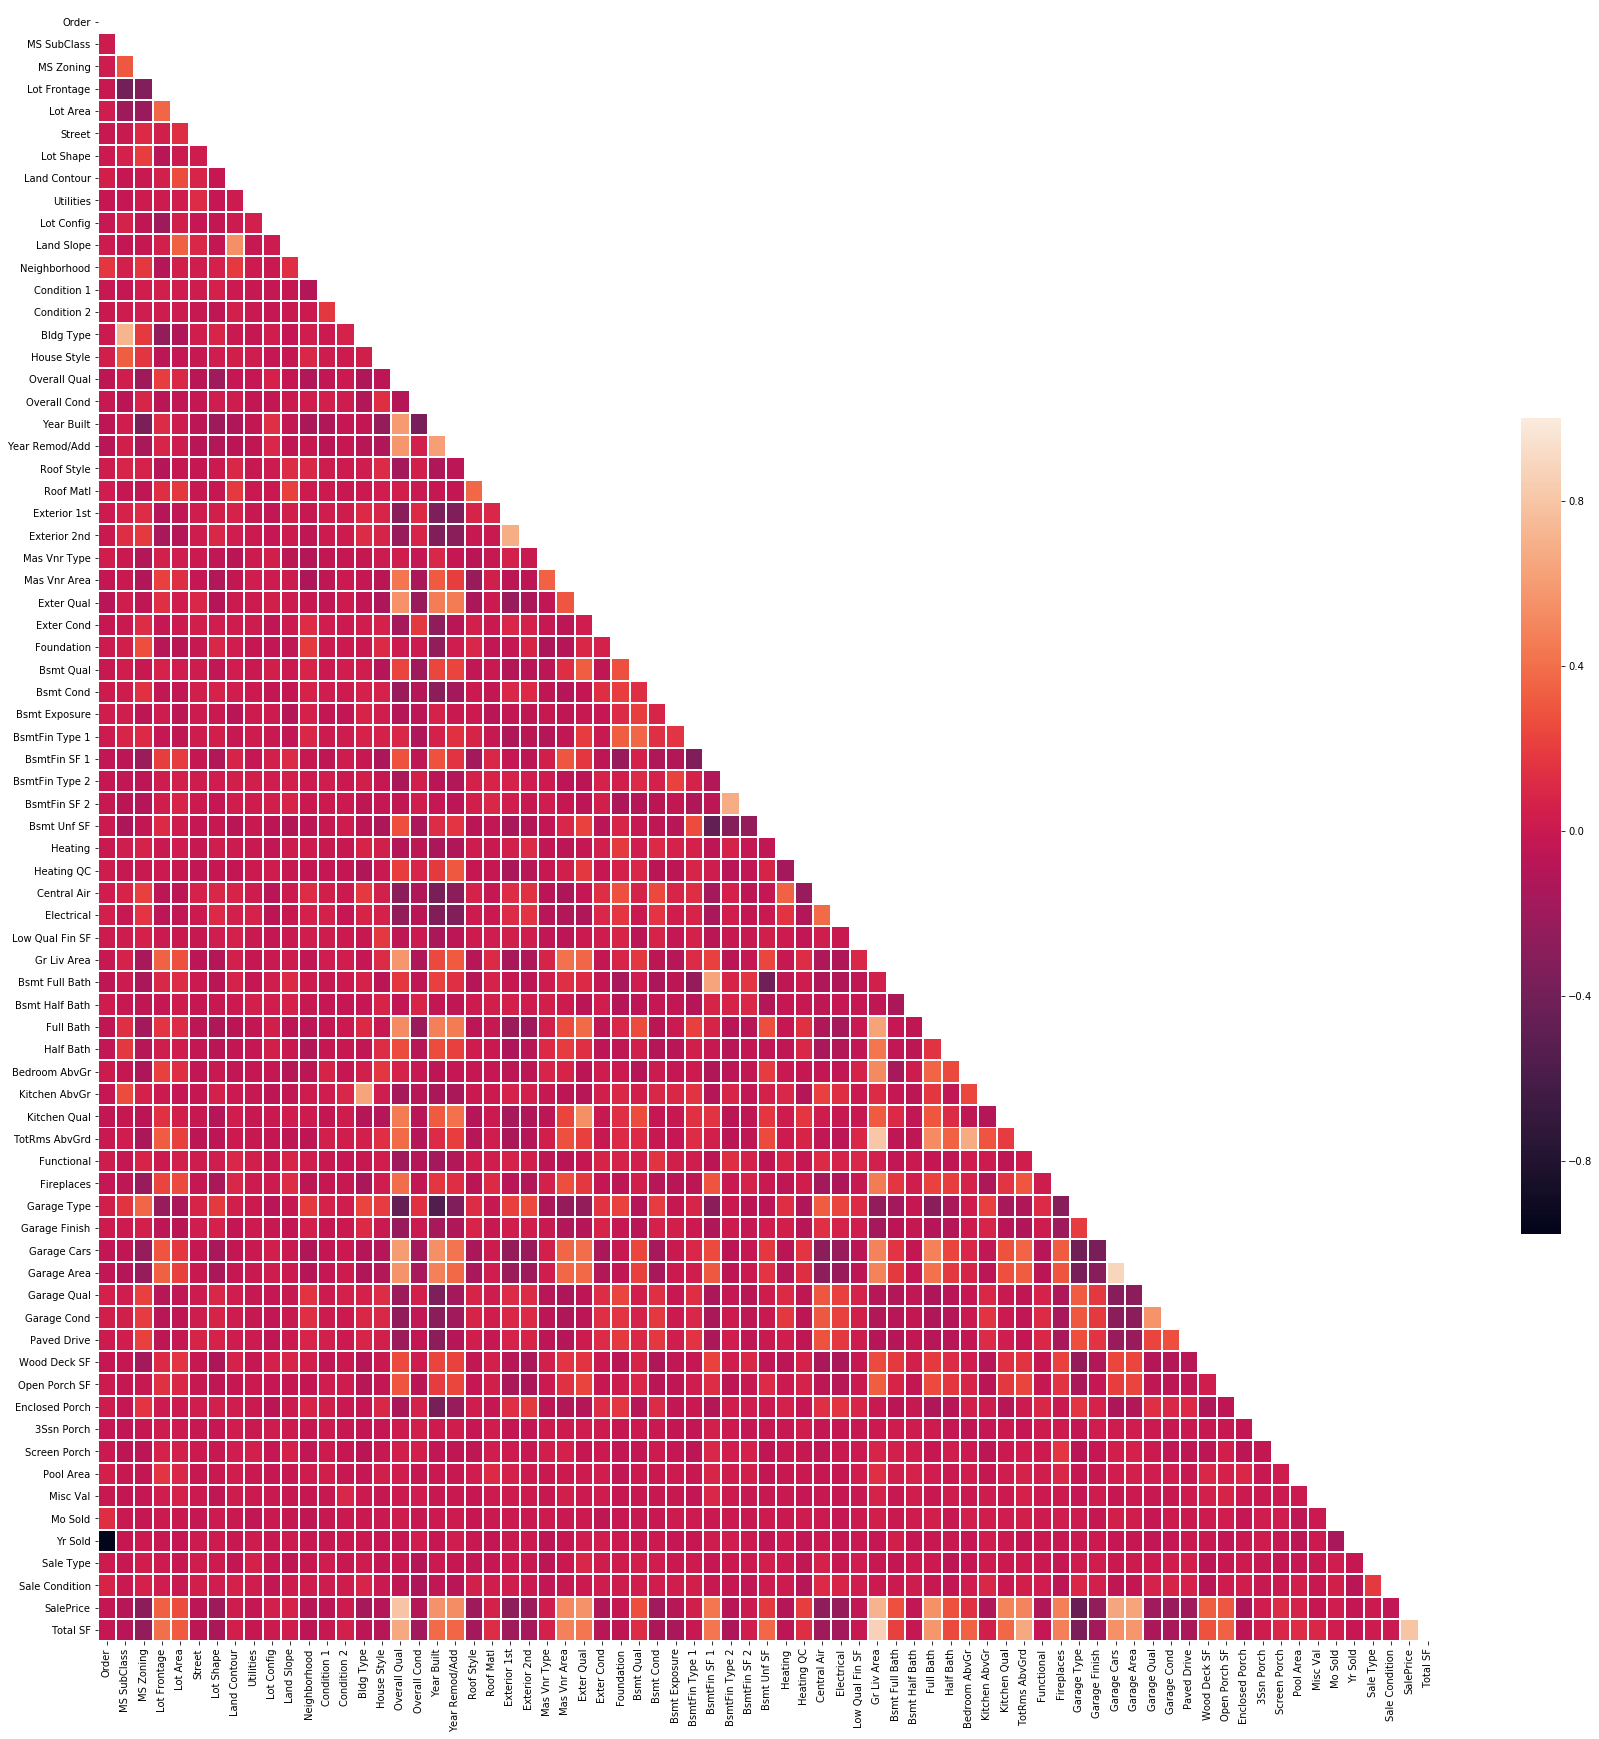

In [35]:
# correlation matrix 
corr = ames_df.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize = (30, 30))
sns.heatmap(corr, mask = mask, xticklabels = 1, 
            yticklabels = 1, linewidths = 1, cbar_kws = {"shrink": .5})

In [39]:
corr = ames_df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
corr = corr.SalePrice
corr

SalePrice          1.000000
Overall Qual       0.799121
Total SF           0.793600
Gr Liv Area        0.708248
Garage Cars        0.647001
Garage Area        0.639161
Exter Qual         0.558493
Year Built         0.558468
Full Bath          0.546100
Year Remod/Add     0.532265
Mas Vnr Area       0.508606
TotRms AbvGrd      0.496296
Kitchen Qual       0.486550
Fireplaces         0.474912
BsmtFin SF 1       0.433796
Lot Frontage       0.339754
Wood Deck SF       0.328813
Open Porch SF      0.307211
Half Bath          0.282143
Bsmt Full Bath     0.276703
Bsmt Qual          0.274037
Lot Area           0.265792
Heating QC         0.200258
Bsmt Unf SF        0.183368
Bedroom AbvGr      0.144928
Screen Porch       0.114262
Pool Area          0.069103
Land Slope         0.067872
Roof Matl          0.064468
Lot Config         0.057203
                     ...   
Bsmt Half Bath    -0.034763
Low Qual Fin SF   -0.037359
Sale Condition    -0.041916
Street            -0.059526
Condition 1       -0

In [68]:
def corrank(X):
        df = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))], columns=['Features','corr'])    
        return df.sort_values(by='corr',ascending=False)

corrank_df = corrank(ames_df)
corrank_df.head(10)

,Features,corr
2699,"(SalePrice, log_SalePrice)",0.946121
2530,"(Garage Cars, Garage Area)",0.889494
2234,"(Gr Liv Area, Total SF)",0.868325
1104,"(Overall Qual, log_SalePrice)",0.825539
2212,"(Gr Liv Area, TotRms AbvGrd)",0.807422
1102,"(Overall Qual, SalePrice)",0.799121
2698,"(SalePrice, Total SF)",0.793600
2700,"(Total SF, log_SalePrice)",0.782956
85,"(MS SubClass, Bldg Type)",0.721305
2233,"(Gr Liv Area, SalePrice)",0.708248


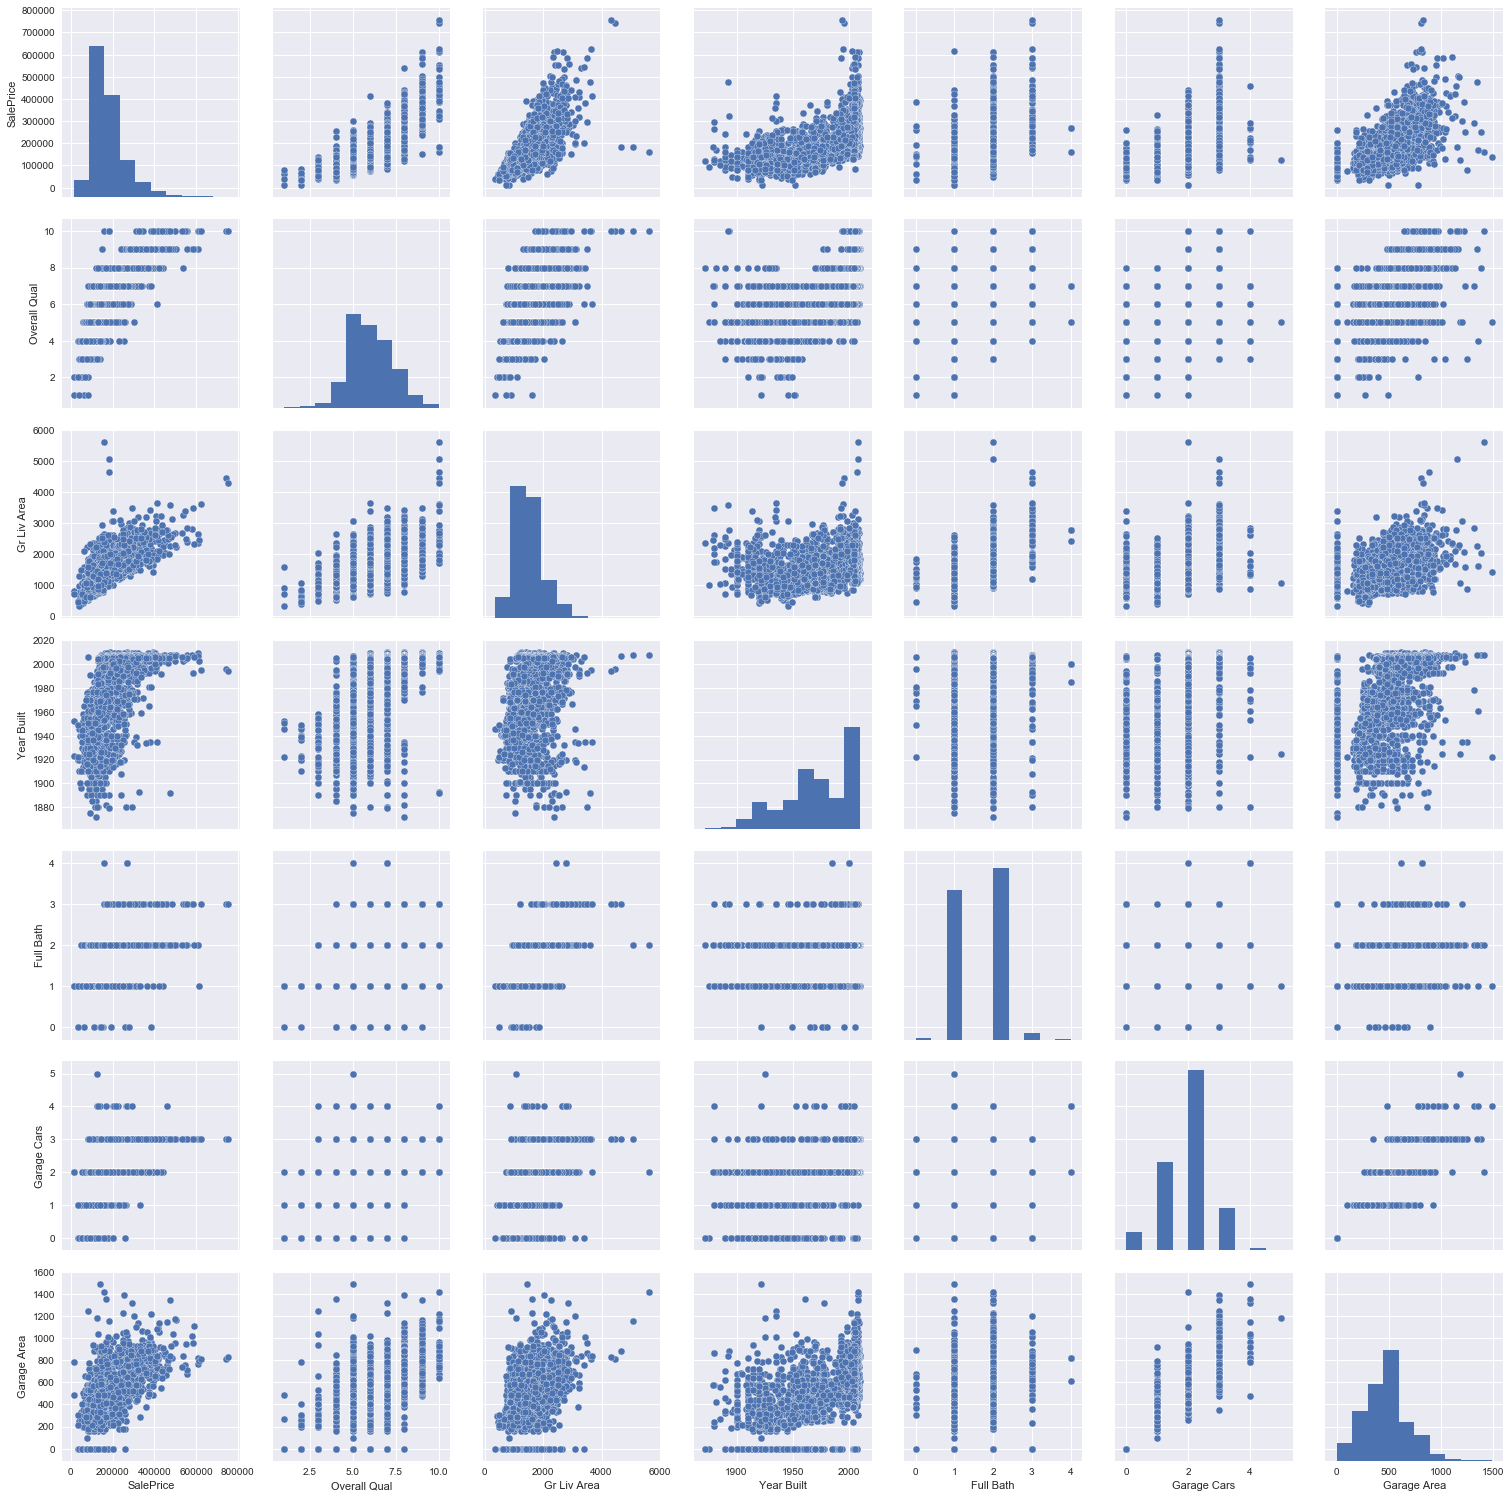

In [69]:
# drawing overall comparisons between top correlated variables
sns.set()
cols = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Year Built', 'Full Bath', 'Garage Cars', 'Garage Area']
sns.pairplot(ames_df[cols], size = 3)
plt.show()

In [42]:
# use linear regression to see check residual distribution

def make_plots(ames_features , start_index, end_index ):
    for i in ames_features[start_index:end_index]:
        x,y = ames_df[i],ames_df.SalePrice
        fig,axs=plt.subplots(1,3,figsize=(10,4))
        sns.boxplot(x,orient='v',ax=axs[0])
        sns.regplot(x,np.log(y),ax=axs[1])
        sns.regplot(x,y,ax=axs[2])
        plt.tight_layout()
        print(i, "done")
        
# eliminate plots2 and combine it. can't figure out how to overload
# leaving overloading for now
def make_plots2( var_x , var_y ):
        x,y = var_x, var_y            
        fig,axs=plt.subplots(1,3,figsize=(10,4))
        sns.boxplot(x,orient='v',ax=axs[0])
        sns.regplot(x,np.log(y),ax=axs[1])
        sns.regplot(x,y,ax=axs[2])
        plt.tight_layout()

In [48]:
len(qualitative)

38

Condition 2 done
Garage Qual done
BsmtFin Type 2 done
Kitchen Qual done
Land Slope done
MS Zoning done
Lot Config done
Central Air done
Garage Type done
Roof Style done
BsmtFin Type 1 done
Mas Vnr Type done
Condition 1 done
Utilities done
Paved Drive done
Functional done
Land Contour done
Bsmt Exposure done
Sale Type done
Bsmt Qual done


/opt/anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Foundation done
House Style done
Bldg Type done
Heating QC done
Street done
Lot Shape done
Exterior 2nd done
Exter Qual done
Garage Cond done
Garage Finish done
Exterior 1st done
Neighborhood done
Exter Cond done
Bsmt Cond done
Sale Condition done


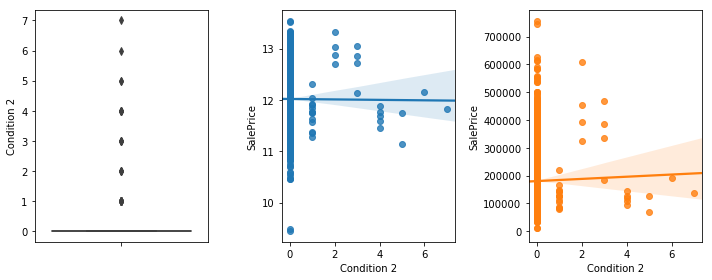

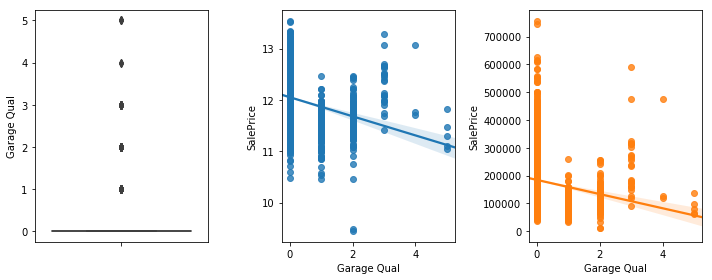

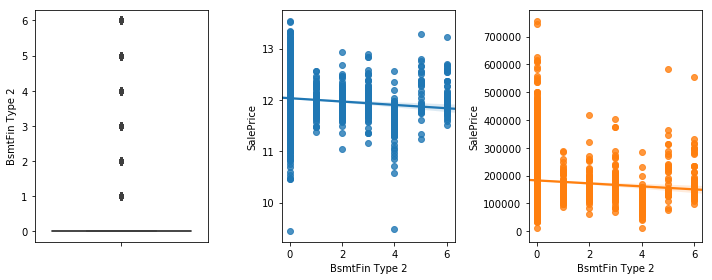

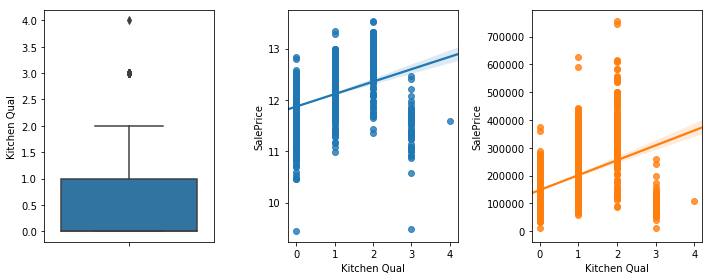

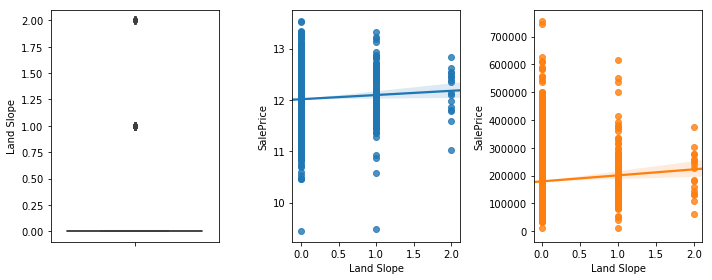

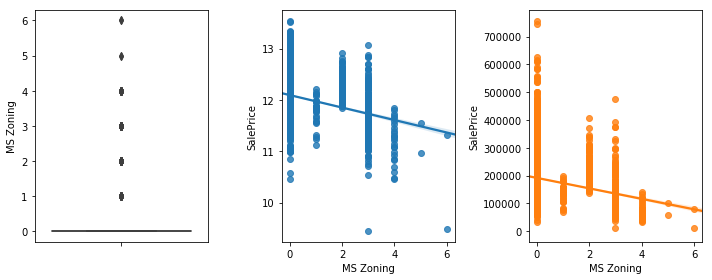

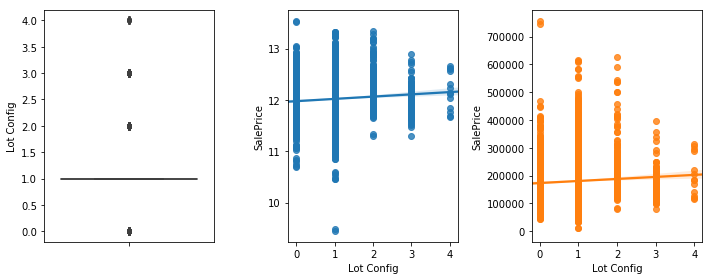

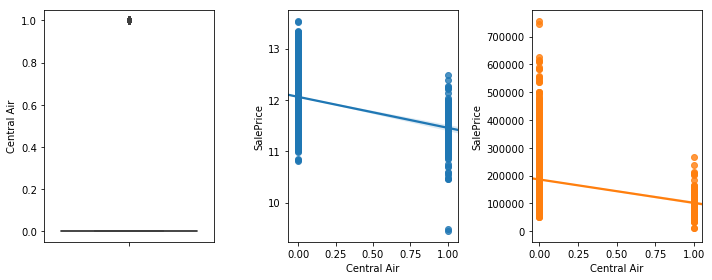

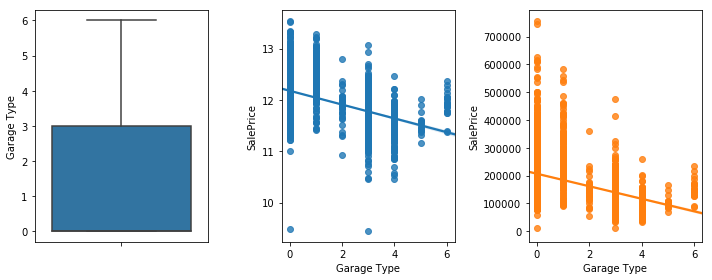

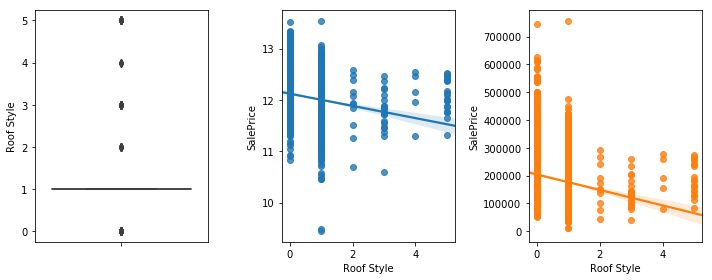

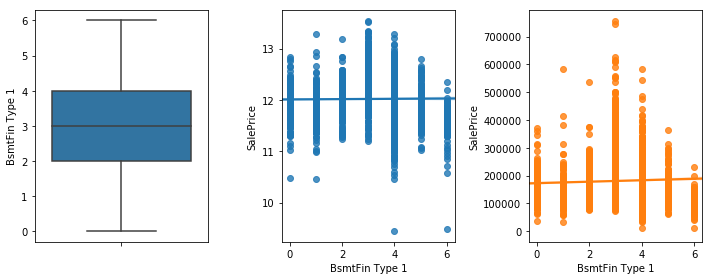

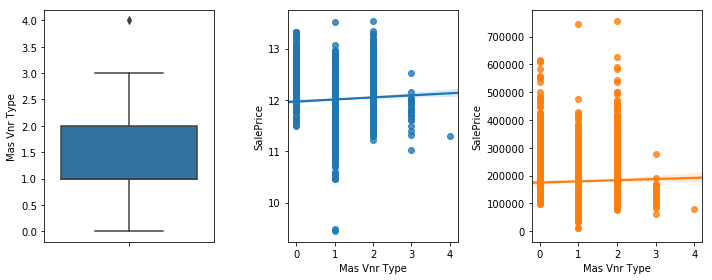

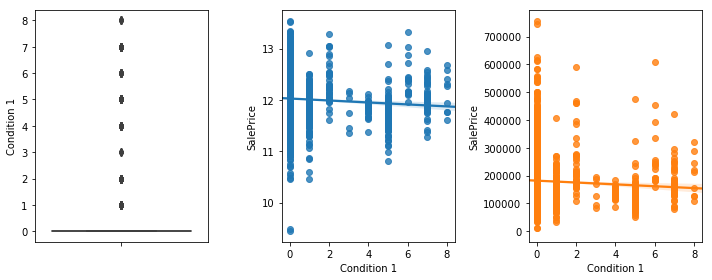

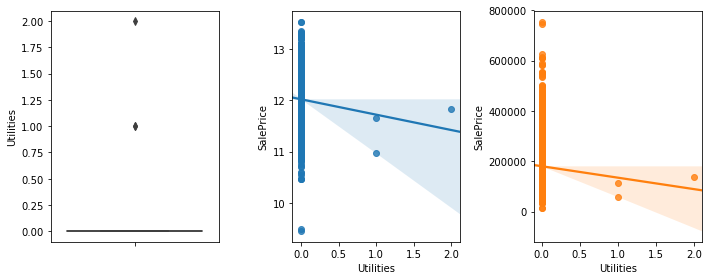

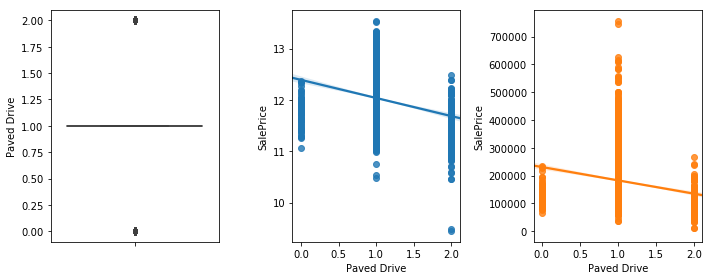

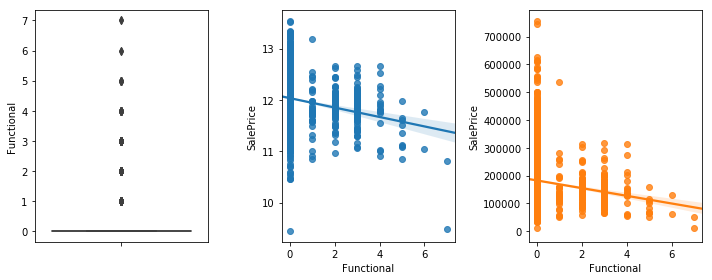

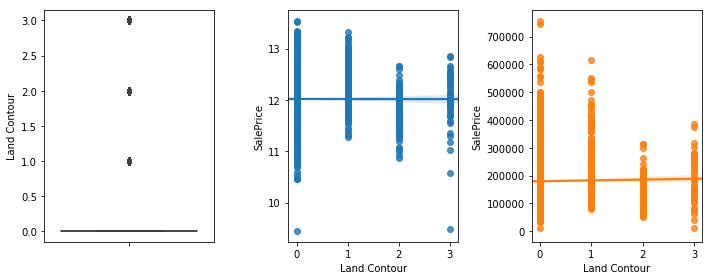

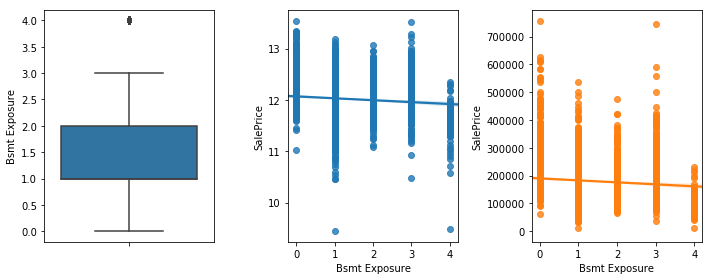

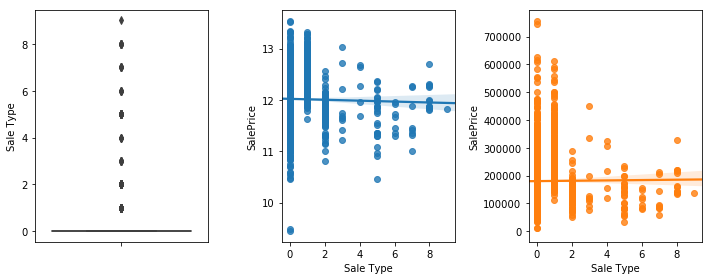

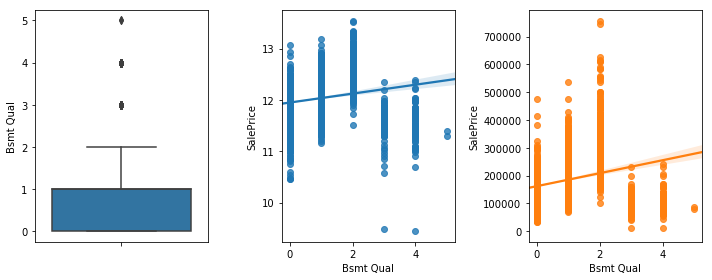

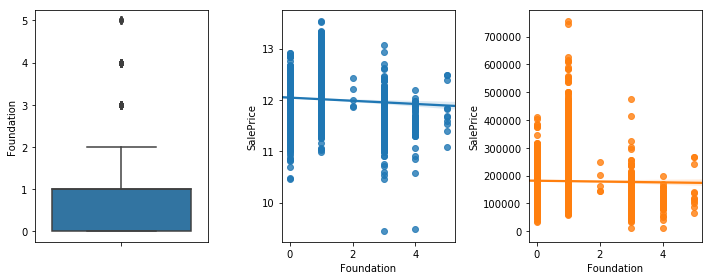

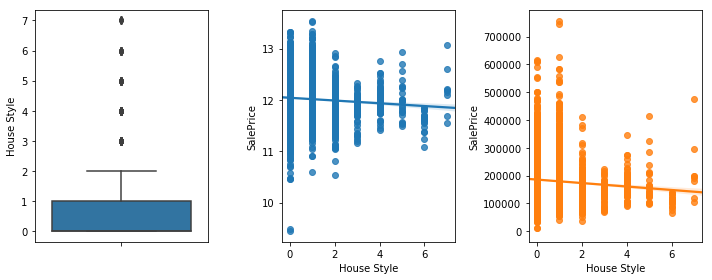

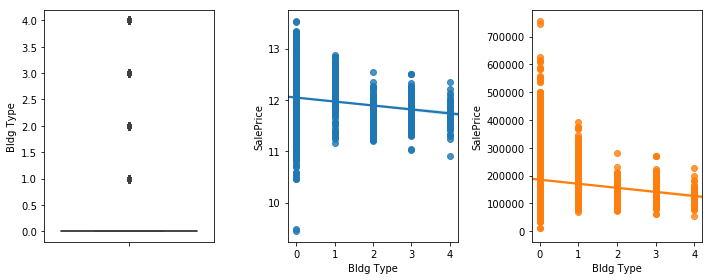

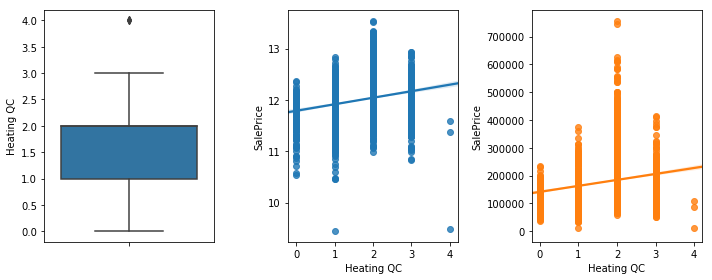

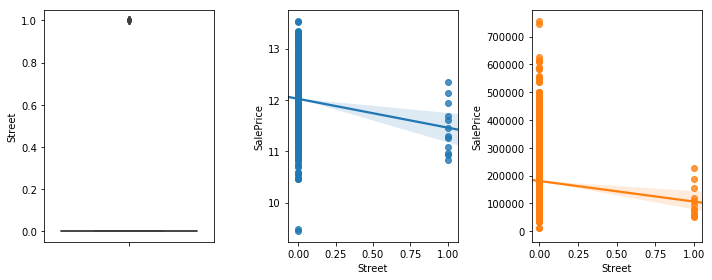

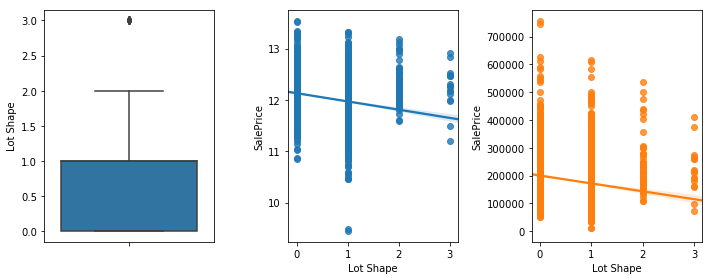

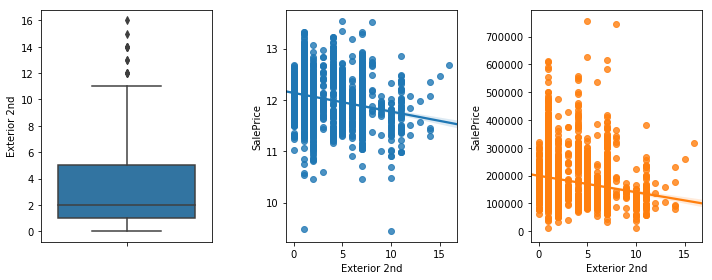

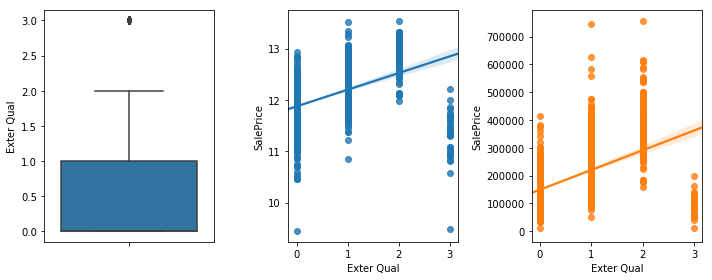

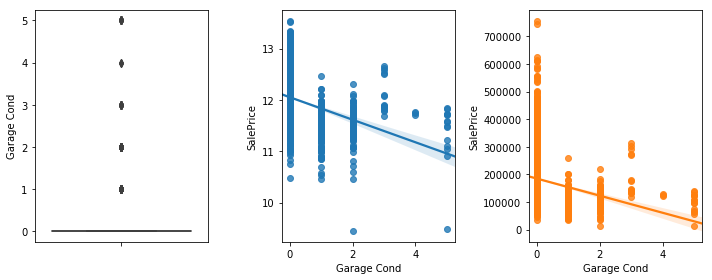

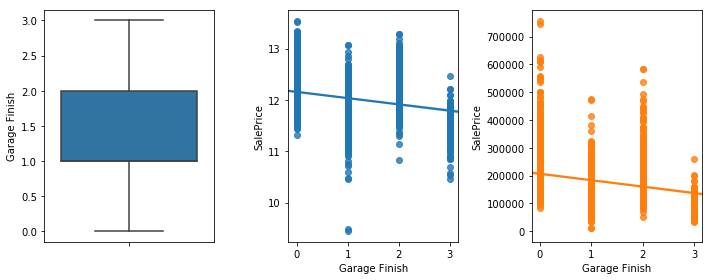

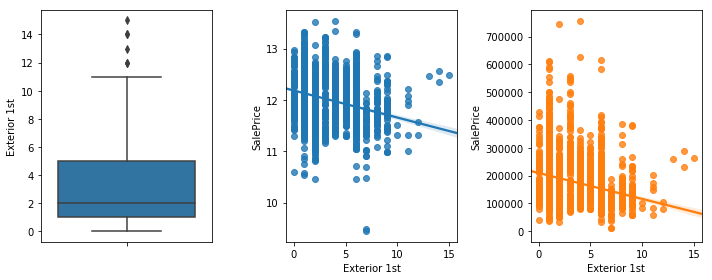

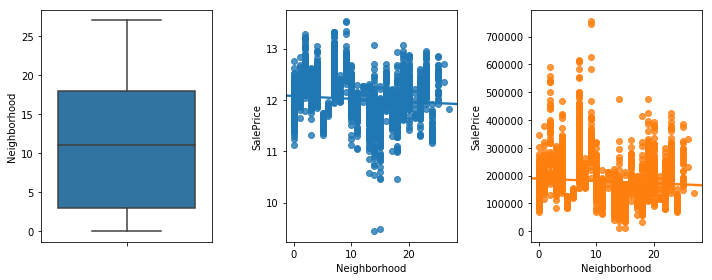

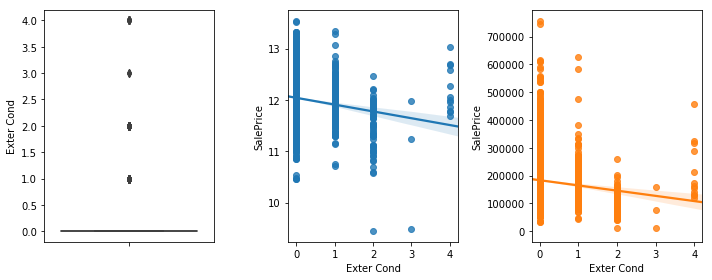

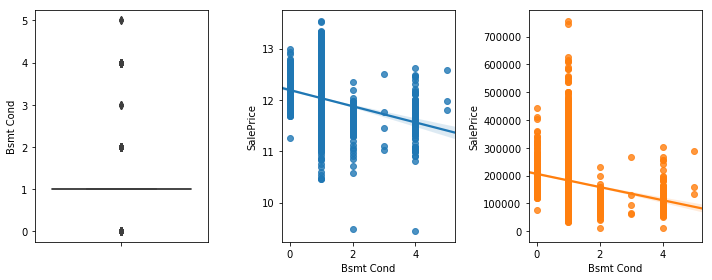

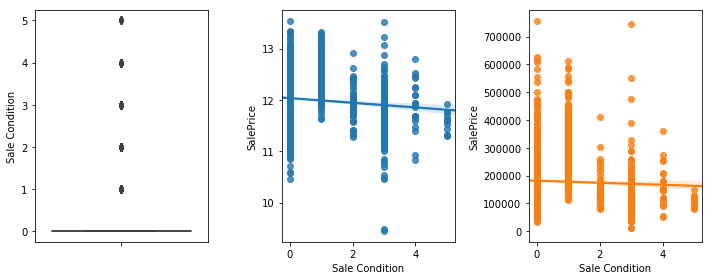

In [47]:
ames_features = qualitative
start_index = 0
end_index = 35
make_plots(ames_features, start_index, end_index)
# quick note- may need to convert mapping index to dict from list

yet to write inferences for all plots

/opt/anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


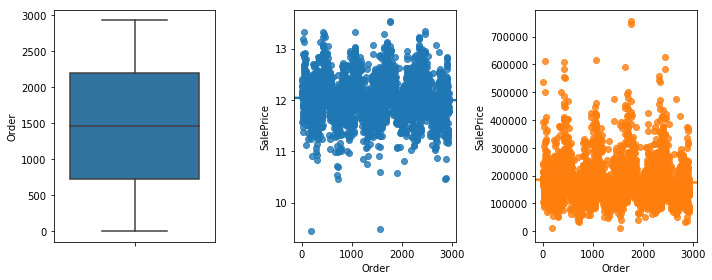

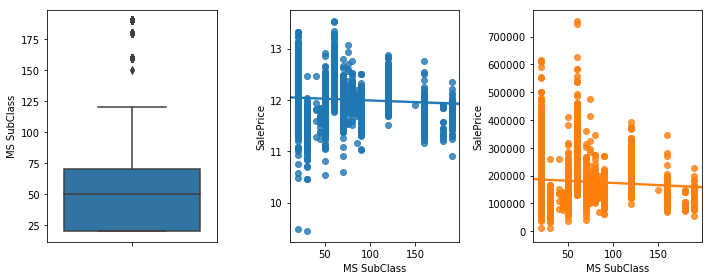

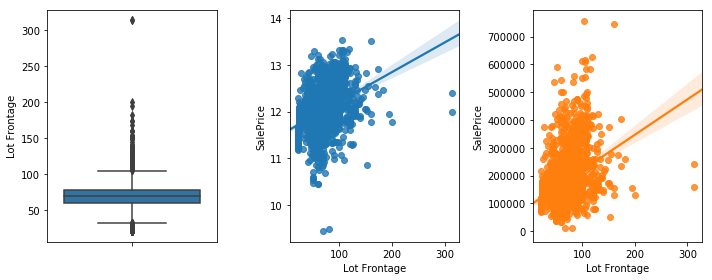

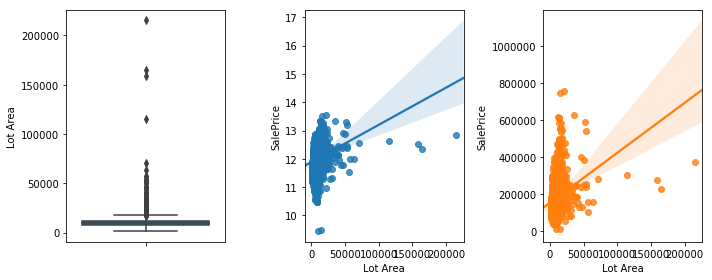

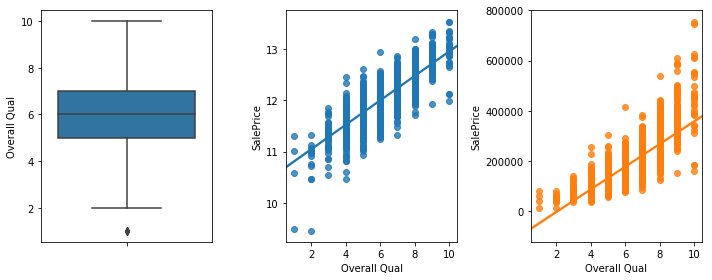

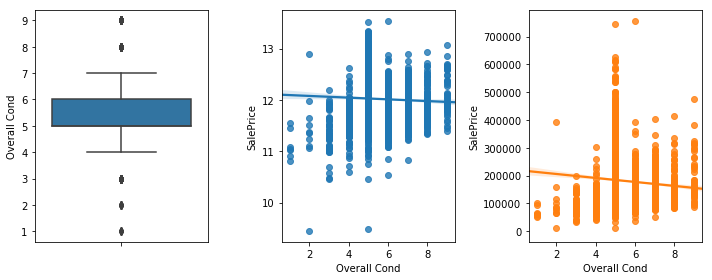

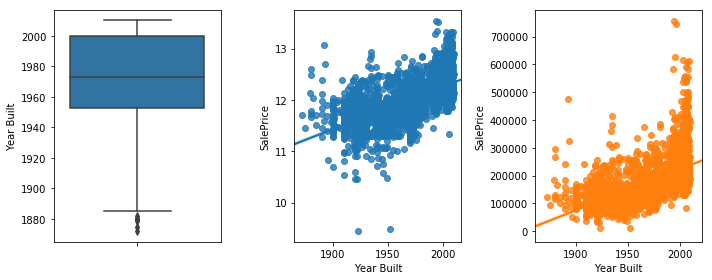

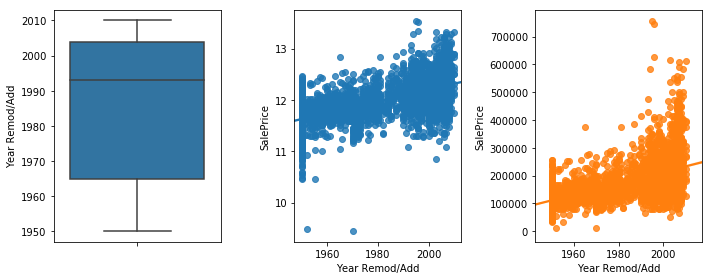

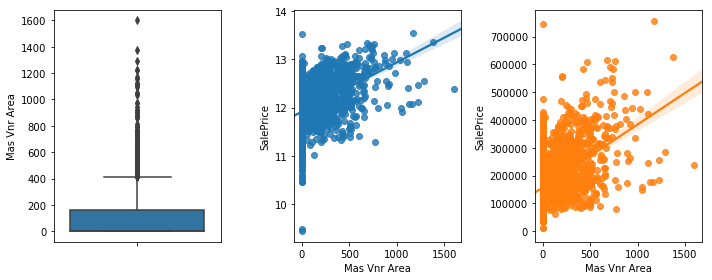

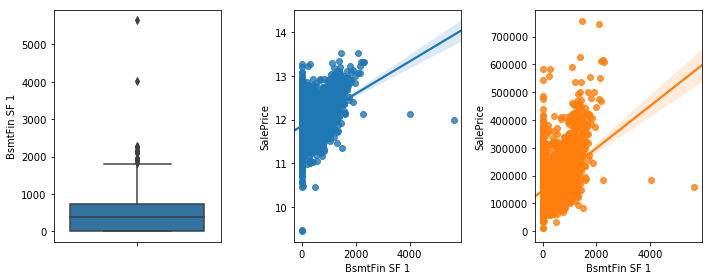

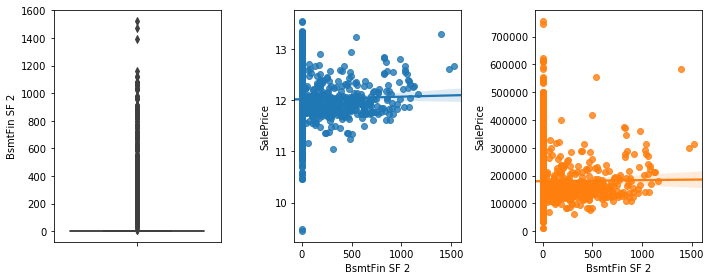

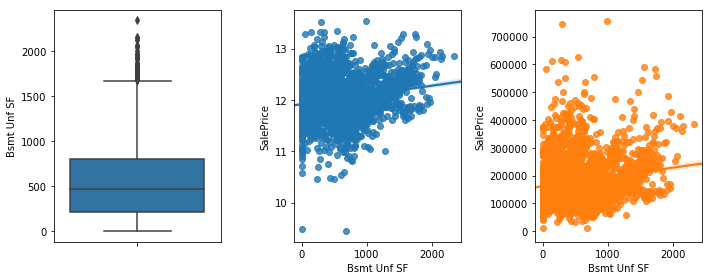

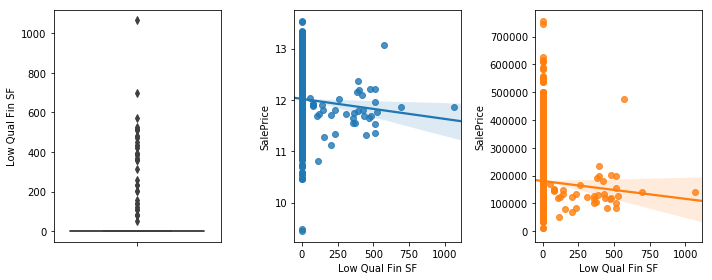

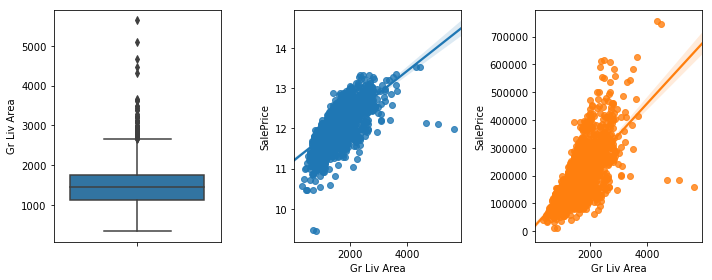

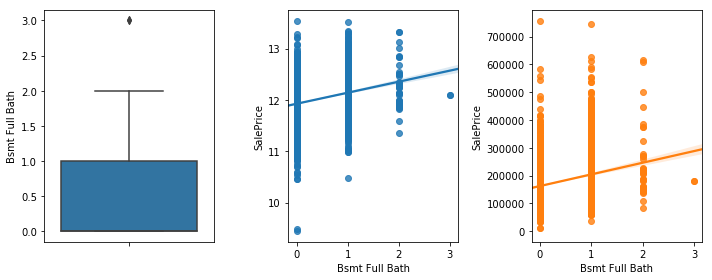

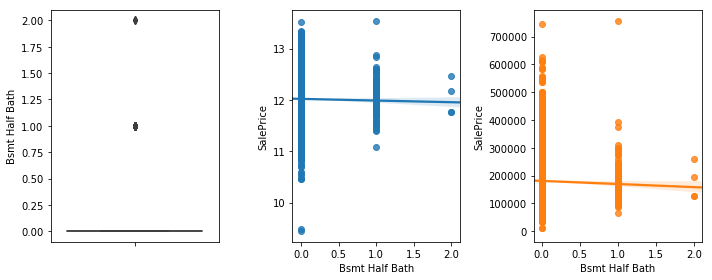

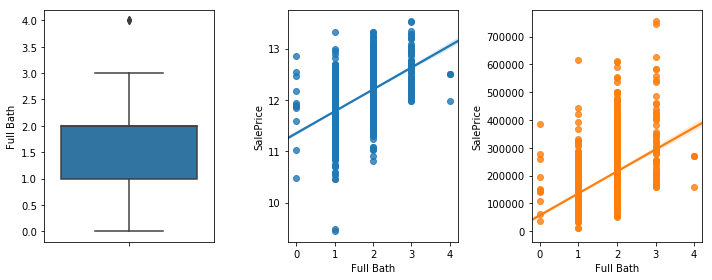

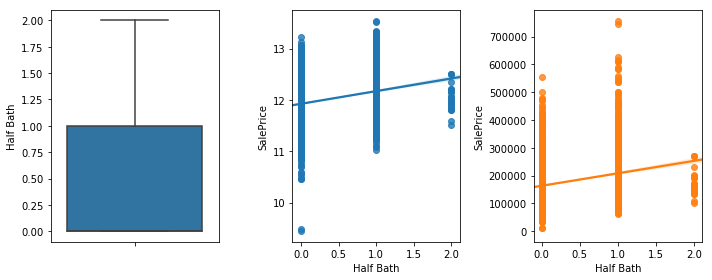

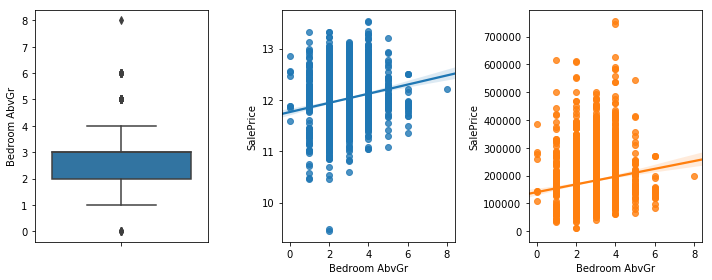

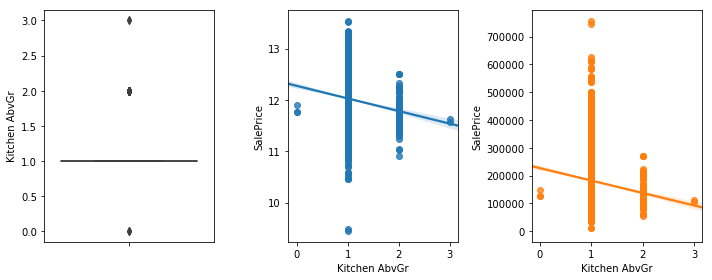

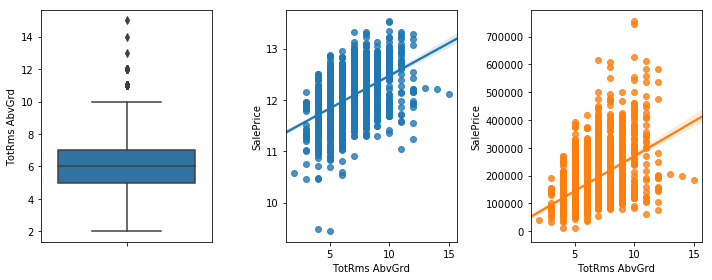

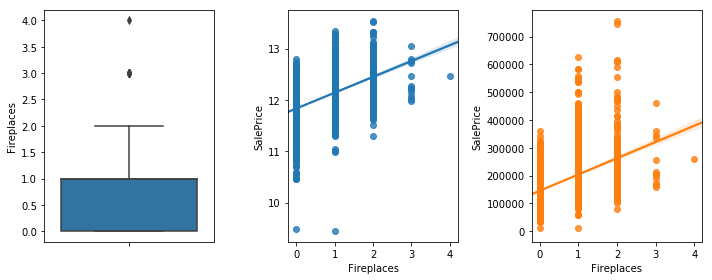

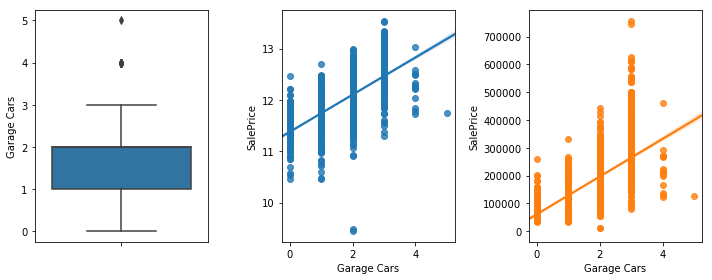

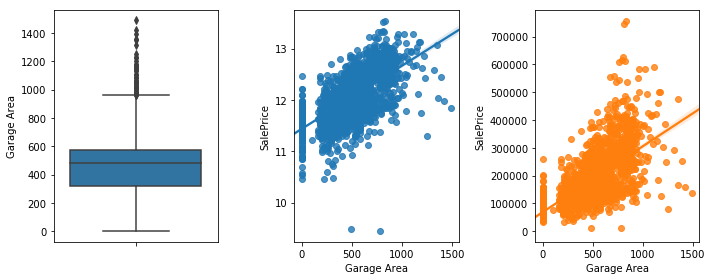

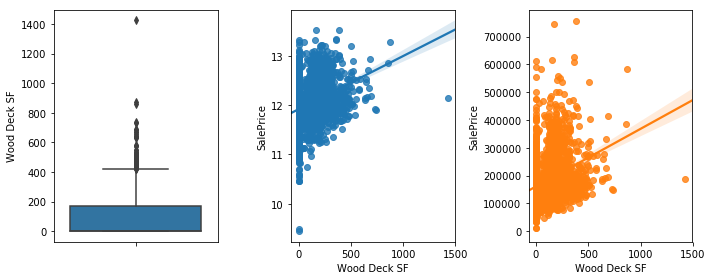

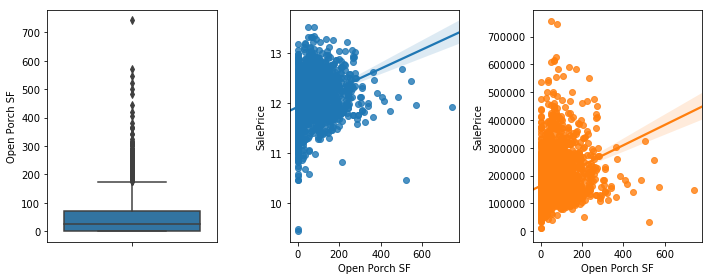

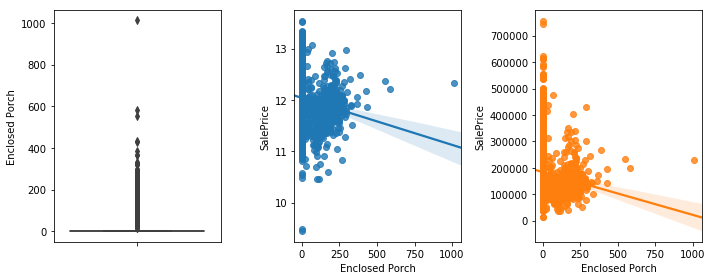

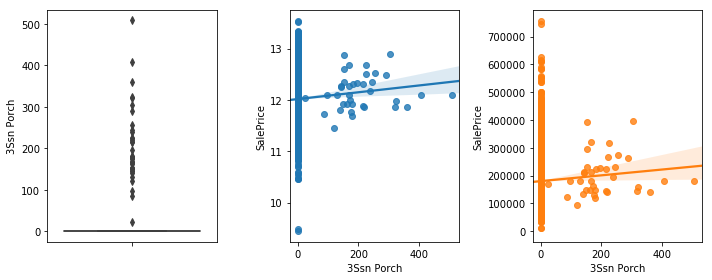

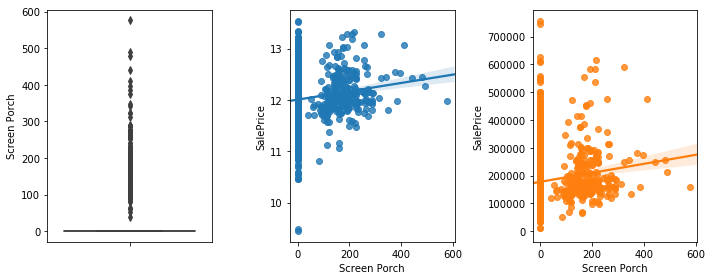

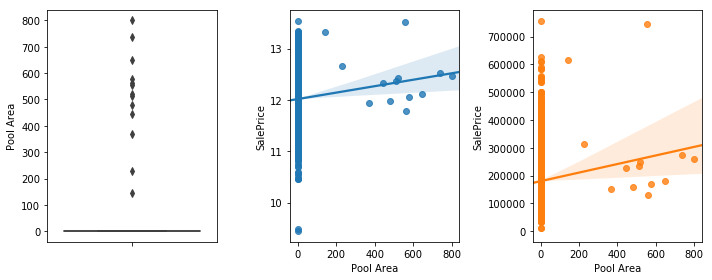

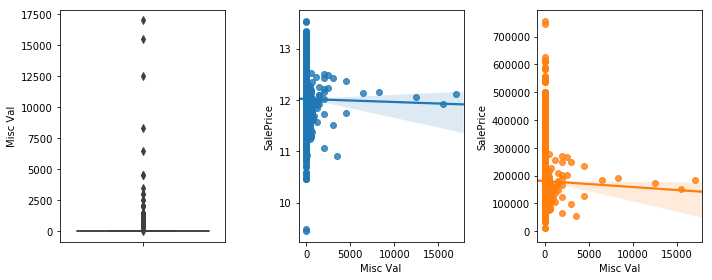

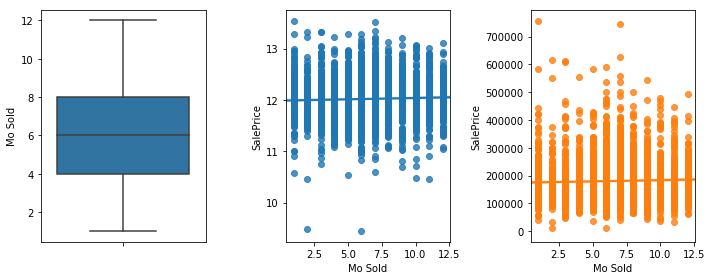

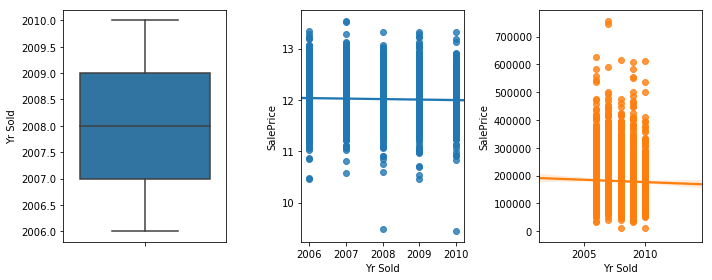

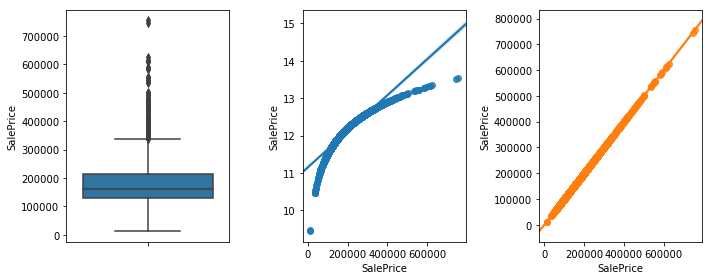

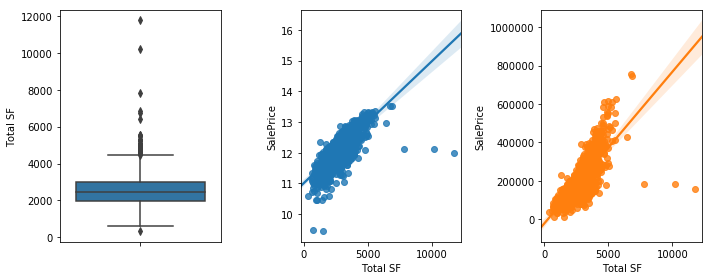

In [55]:
var_y = ames_df.SalePrice
for var_x in quantitative:
    make_plots2(ames_df[var_x] , var_y)

yet to write inferences for all plots

In [ ]:
# ML part

In [67]:
ames_df['SalePrice'].describe()

count      2903.000000
mean     180393.842921
std       79814.696125
min       12789.000000
25%      129100.000000
50%      160000.000000
75%      213000.000000
max      755000.000000
Name: SalePrice, dtype: float64

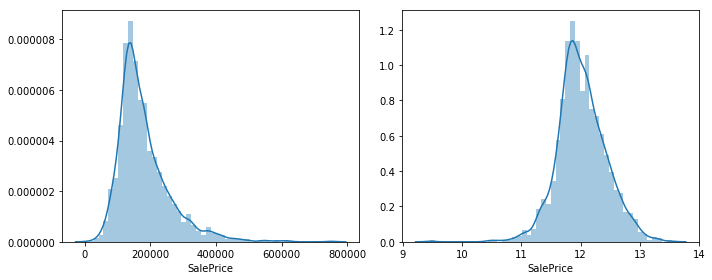

In [56]:
ames_sp = ames_df['SalePrice']
ames_sp_log = np.log(ames_sp)
fig, axs=plt.subplots(1,2,figsize=(10,4))
sns.distplot(ames_sp, ax = axs[0])
sns.distplot(ames_sp_log, ax = axs[1])
plt.tight_layout()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(ames_df.drop('SalePrice', axis=1), 
                                                    ames_df["SalePrice"], test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1945, 72)
(958, 72)
(1945,)
(958,)


In [65]:
# R2 and RMSE
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Accuracy Scores   
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    print(estimator)
    print("Training Score = ")
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    print("Testing Score = ")
    get_score(prediction_test, y_tst)

In [58]:
gbr = GradientBoostingRegressor(n_estimators=12000,
            learning_rate=0.05, max_depth=3, max_features='sqrt',
            min_samples_leaf=15, min_samples_split=10, loss='huber')

gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=12000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [66]:
train_test(gbr, X_train, X_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=12000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
Training Score = 
R2: 0.9926757954901043
RMSE: 6788.72405827726
Testing Score = 
R2: 0.9117550325763886
RMSE: 21862.987643655408


References:

https://www.kaggle.com/maviator/simple-sklearn-models-averaging-to-get-to-13